# Semantic Segmentation of Cells

In this notebook, I will be exploring and testing my model for segmenting images by cells. This will serve as the starting point for **Instance Segmentation** and then **Graph Construction**

In [38]:


import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps
import os
import sys
from pathlib import Path
from math import inf
from tqdm import tqdm

from torchvision.transforms import Compose, ToPILImage
import torch

top_folder = str(Path(os.getcwd()).parent.parent)
sys.path.append(top_folder)

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

%matplotlib widget

## Data Preperation

In [39]:
# swap color axis because
# numpy image: H x W x C
# torch image: C x H x W

def tensor_to_numpy(tensor):
    return np.asarray(ToPILImage()(tensor))

### No Transforms

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
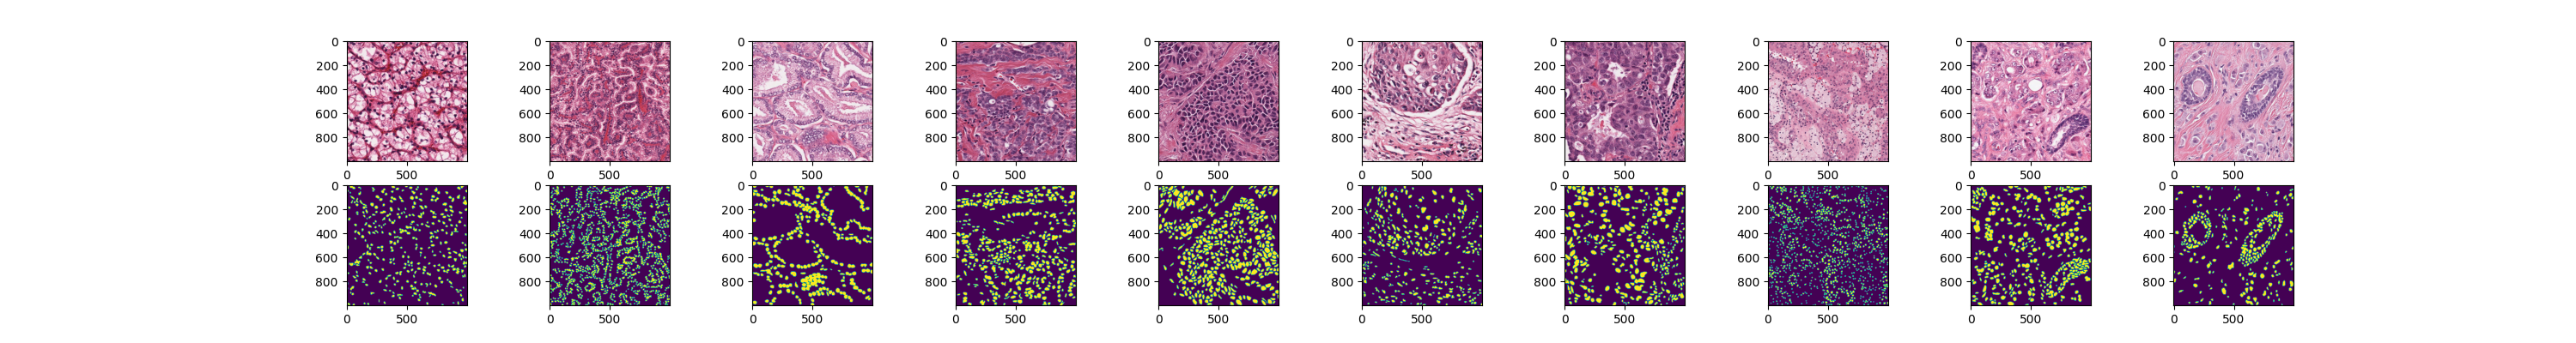

In [40]:
from src.datasets.MoNuSeg import MoNuSeg
from torch.utils.data import DataLoader
from src.transforms.MoNuSeg import ToTensor

dl = DataLoader(MoNuSeg(os.path.join(top_folder,"data","processed","MoNuSeg"),transform=ToTensor()), batch_size=1, shuffle=True, num_workers=1)

f,ax = plt.subplots(2,10,figsize=(30,4))

for i,img in enumerate(dl):
    ax[0,i].imshow(tensor_to_numpy(img['image'].squeeze())) #as is batch 1 need to squeeze
    ax[1,i].imshow(tensor_to_numpy(img['semantic_mask'].squeeze()))
    if i==9:
        plt.show()
        break
    
    


In [41]:
# Figure out the normalization terms

mean_tensor,std_tensor = torch.zeros(3),torch.zeros(3)
for img in dl:
    he = img['image'].squeeze().float() #need to convert to float as is otherwise a byte (8bit depth)
    std_mean = torch.std_mean(he,dim=(1,2))
    std_tensor += std_mean[0]
    mean_tensor += std_mean[1]
mean_tensor = torch.div(mean_tensor,len(dl))
std_tensor = torch.div(std_tensor,len(dl))

print(f"The mean colour of the image is: {mean_tensor}")
print(f"The standard deviation of the images is: {std_tensor}")

The mean colour of the image is: tensor([0.6441, 0.4474, 0.6039])
The standard deviation of the images is: tensor([0.1892, 0.1922, 0.1535])


#### Experimenting Transforms

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
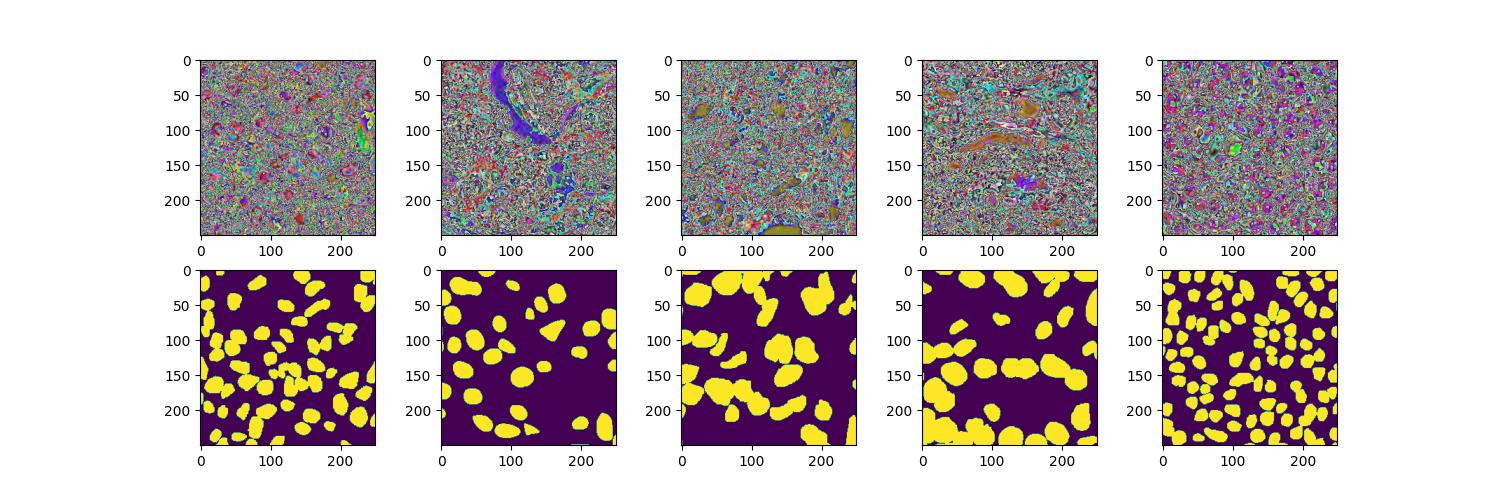

In [42]:
from src.transforms.MoNuSeg import Normalize,ToTensor,RandomCrop
from random import random

size = (250,250)
transforms = Compose([ToTensor(),Normalize([0.6441, 0.4474, 0.6039],[0.1892, 0.1922, 0.1535]),RandomCrop(size=size)])

dl_trans = DataLoader(MoNuSeg(os.path.join(top_folder,"data","processed","MoNuSeg"),transform=transforms), batch_size=1, shuffle=True, num_workers=1)

f,ax = plt.subplots(2,5,figsize=(15,5))
for i,batch in enumerate(dl_trans):
    img = batch['image'].squeeze()
    mask = batch['semantic_mask'].squeeze()
    ax[0,i].imshow(tensor_to_numpy(img))
    ax[1,i].imshow(tensor_to_numpy(mask))
    if i==4:
        break
plt.show()

# Model

## Pretrained and built

In [43]:
import mlflow

model = mlflow.pytorch.load_model("../../trained_models/cell_seg_v1.pth").cpu()


### Predict

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
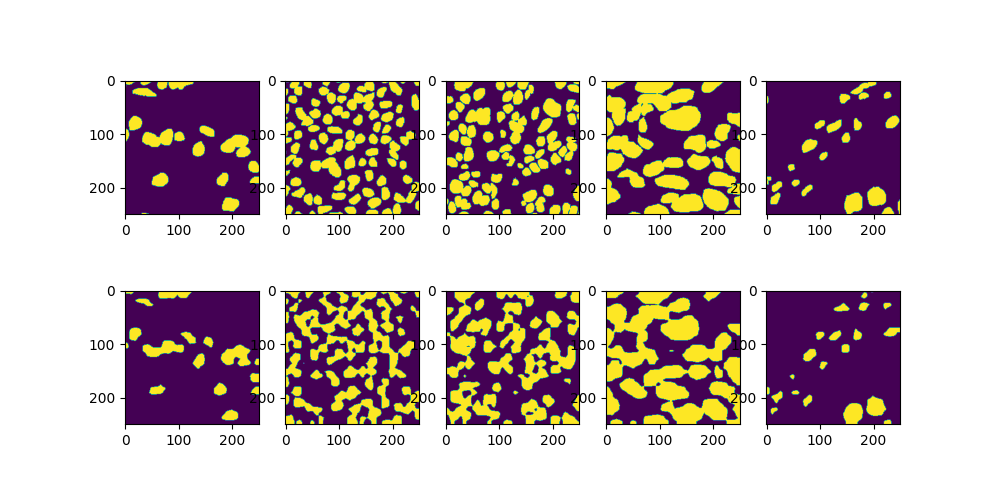

In [44]:
f, ax = plt.subplots(2,5,figsize=(10,5))
for i,batch in enumerate(dl_trans):
    if i ==5:
        break
    pred = model(batch['image']).detach().numpy().squeeze()
    pred[pred>0.5] = 1
    pred[pred<=0.5] = 0
    ax[0,i].imshow(batch['semantic_mask'].squeeze())
    ax[1,i].imshow(pred)


## Observations

If you train the model on 250x250 crops, then try to run it on the full 1000x1000 in one go, it fails horribly (detects nothing). My feeling is that this is because of size and that the smaller images of cells don't quite have the same shape dimensions when enlarged (i.e. curves a lot less slowly)
 - [ ] Train on random sizes, zooms and rotates

Below you can see how a simple, pretrained model finetuned to this data set performs for not very long. On the top is the ground truth, while at the bottom is the predicted mask. There is signed of undersegmentation (cells are grouped together which should be consider distinct). I have some ideas of how to seperate these instances.

![](img/pre_trained_img_seg_performance.png)

There are also some weird artifacts that are being produced:

![](img/weird_artifacts.png)

# Instance Segmentation

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
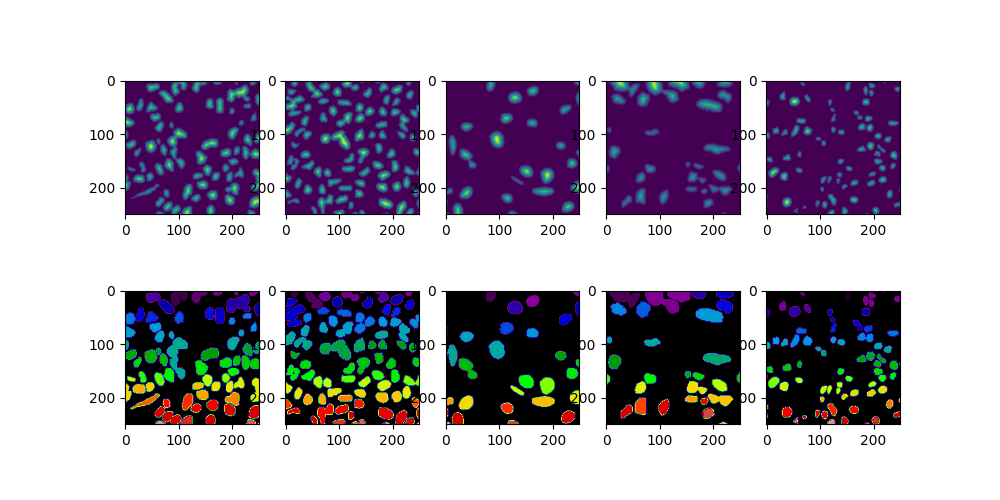

In [45]:
from src.model.graph_construction.cell_instance_segmentation import instance_segment
from scipy.ndimage import distance_transform_edt
#todo fix

f, ax = plt.subplots(2,5,figsize=(10,5))
for i,batch in enumerate(dl_trans):
    if i ==5:
        break
    #pred = model(batch['image']).detach().int().numpy().squeeze()
    distance = distance_transform_edt(batch['semantic_mask'].squeeze())
    ax[0,i].imshow(distance)
    ax[1,i].imshow(instance_segment(batch['semantic_mask'].squeeze().int().numpy()),cmap=plt.cm.nipy_spectral)
    #ax[0,i].imshow(instance_segment(batch['semantic_mask'].squeeze().int().numpy()),cmap=plt.cm.nipy_spectral)
   # ax[1,i].imshow(pred,cmap=plt.cm.nipy_spectral)
plt.show()



Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
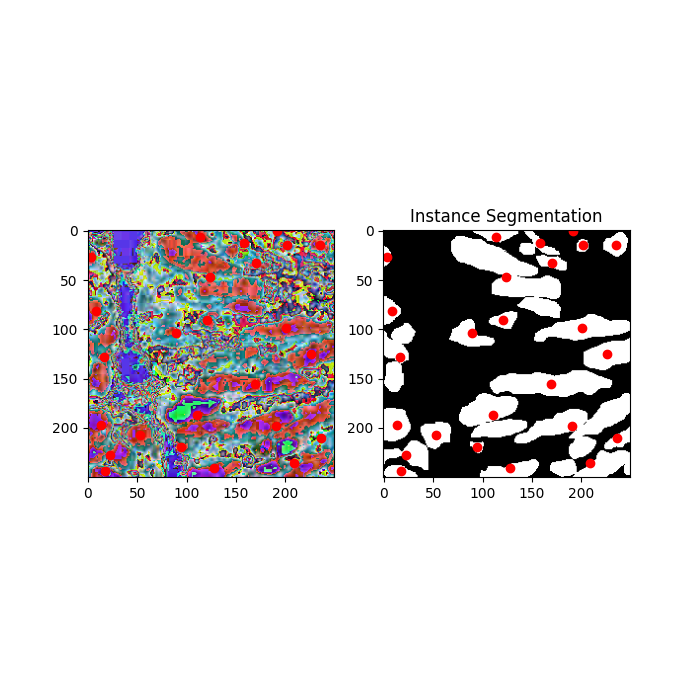

In [48]:
from src.model.graph_construction.graph_extraction import create_featureless_graph

batch = list(dl_trans)[0]
mask = batch['semantic_mask'].squeeze().int().numpy()
img = batch['image'].squeeze()
ins_seg = instance_segment(mask)
graph = create_featureless_graph(ins_seg)

f,ax = plt.subplots(1,2,figsize=(7,7))
points = list(graph.nodes.values())
x,y = map(list,zip(*points))

ax[0].imshow(tensor_to_numpy(img))
ax[0].scatter(x,y,c="r")
ax[1].imshow(1-mask,cmap="binary")
ax[1].scatter(x,y,c="r")
plt.title("Instance Segmentation")
plt.show()
